# １．各種importなど

In [0]:
# VGG16のモデルを作成する
# 各種import など

# !pip install  tf-nightly-2.0-preview
#!pip install tensorflow==1.14.0

%matplotlib inline

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from IPython.display import Image, display_png
import json

# digitsデータを使うためにimportする
from torchvision.datasets import MNIST
import torchvision

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

%tensorflow_version 1.x
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D,Input
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import CSVLogger
from keras.optimizers import Adam

cuda


Using TensorFlow backend.


In [0]:
import keras.backend as K

#precision
def P(y_true, y_pred):
    true_positives = K.sum(K.cast(K.greater(K.clip(y_true * y_pred, 0, 1), 0.20), 'float32'))
    pred_positives = K.sum(K.cast(K.greater(K.clip(y_pred, 0, 1), 0.20), 'float32'))

    precision = true_positives / (pred_positives + K.epsilon())
    return precision

#recall
def R(y_true, y_pred):
    true_positives = K.sum(K.cast(K.greater(K.clip(y_true * y_pred, 0, 1), 0.20), 'float32'))
    poss_positives = K.sum(K.cast(K.greater(K.clip(y_true, 0, 1), 0.20), 'float32'))

    recall = true_positives / (poss_positives + K.epsilon())
    return recall

#f-measure
def F(y_true, y_pred):
    p_val = P(y_true, y_pred)
    r_val = R(y_true, y_pred)
    f_val = 2*p_val*r_val / (p_val + r_val)

    return f_val

# ２．学習用ファイルを読み込み

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd /content/drive/'My Drive'/データサイエンス学習/integration/imgs/vgg_imgs

/content/drive/My Drive/データサイエンス学習/integration/imgs/vgg_imgs


In [0]:
ls

1_x_entropy_acc.csv      3_optimizer_default.h5    train/
1_x_entropy_acc.h5       3_optimizer_default.json  validation/
1_x_entropy_acc.json     display/                  結果まとめ.gsheet
2_vgg_SVM.csv            test/
3_optimizer_default.csv  test_moresuit/


In [0]:
train_dir='train'
validation_dir='validation'
test_dir='test'

#モデルデータを別名保存するため可変。
file_name='1_x_entropy_acc'
#file_name='3_optimizer_default'

# ３．VGG16ベースモデルを読み込み

In [1]:
# VGG16の学習済みモデルを生成する。
# imagenetの学習済み重みデータを利用
# 結合層は自作するので include_top=False

n_categories = 2
batch_size = 32

base_model = VGG16(weights = 'imagenet',include_top=False,
                 input_tensor = Input(shape=(224,224,3)))

NameError: ignored

# ４．学習用結合層を作成

In [0]:
#結合層生成
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
prediction=Dense(1,activation='sigmoid')(x)

#結合層をくっつけた完成形modelを作成
model=Model(inputs=base_model.input,outputs=prediction)

#fix weights before VGG16 14layers
for layer in base_model.layers[:15]:
    layer.trainable=False


# loss function=AUCを利用。
# metrics = accuracyを利用。
opt_sgd=SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
opt_adam=Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#Adam

model.compile(optimizer=SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True),
              loss=['binary_crossentropy'],
              metrics=['accuracy',P,R,F],
              )

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

# ５．モデルを利用した訓練

In [0]:
# 作成したモデルで訓練する
# 利用するデータを用意する
train_datagen=ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    horizontal_flip=True)

validation_datagen=ImageDataGenerator(rescale=1.0/255)

train_generator=train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator=validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

hist=model.fit_generator(train_generator,
                         epochs=100,
                         verbose=1,
                         validation_data=validation_generator,
                         callbacks=[CSVLogger(file_name+'.csv')])

Found 267 images belonging to 2 classes.
Found 81 images belonging to 2 classes.
Epoch 1/100
9/9 [==============================] - 6s 688ms/step - loss: 0.7171 - acc: 0.4008 - P: 0.5000 - R: 1.0000 - F: 0.6667 - val_loss: 0.6831 - val_acc: 0.5926 - val_P: 0.5000 - val_R: 1.0000 - val_F: 0.6667
Epoch 2/100
9/9 [==============================] - 6s 613ms/step - loss: 0.6552 - acc: 0.6492 - P: 0.5000 - R: 1.0000 - F: 0.6667 - val_loss: 0.6692 - val_acc: 0.6173 - val_P: 0.5000 - val_R: 1.0000 - val_F: 0.6667
Epoch 3/100
9/9 [==============================] - 6s 641ms/step - loss: 0.6354 - acc: 0.6647 - P: 0.5000 - R: 1.0000 - F: 0.6667 - val_loss: 0.6746 - val_acc: 0.6173 - val_P: 0.5000 - val_R: 1.0000 - val_F: 0.6667
Epoch 4/100
9/9 [==============================] - 6s 624ms/step - loss: 0.6345 - acc: 0.6587 - P: 0.5000 - R: 1.0000 - F: 0.6667 - val_loss: 0.6702 - val_acc: 0.6173 - val_P: 0.5000 - val_R: 1.0000 - val_F: 0.6667
Epoch 5/100
9/9 [==============================] - 6s 644ms

KeyboardInterrupt: ignored

# ５−ａ．SVMモデルで最後に学習させる

In [0]:
import numpy
file_name='2_vgg_SVM'

test_datagen=ImageDataGenerator(rescale=1.0/255)
test=test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

train_datagen=ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    horizontal_flip=True)
train=train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)


Found 71 images belonging to 2 classes.
Found 267 images belonging to 2 classes.


In [0]:
train_classes = list()
for cls in train.classes:
  if cls == 0:
    train_classes.append('men_casual')
  else:
    train_classes.append('men_suit')    

test_classes = list()
for cls in test.classes:
  if cls == 0:
    test_classes.append('men_casual')
  else:
    test_classes.append('men_suit') 

In [0]:

base_model = VGG16(weights='imagenet', include_top=False, pooling="avg")

vgg16_train = base_model.predict(train)
vgg16_test = base_model.predict(test)

#SVMで分類
from sklearn.svm import SVC
clf = SVC(kernel="linear").fit(vgg16_train, train_classes)


In [0]:
from sklearn.metrics import accuracy_score

print("acc = {}".format(accuracy_score(clf.predict(vgg16_train), train_classes)))
print("val_acc = {}".format(accuracy_score(clf.predict(vgg16_test), test_classes)))


acc = 0.8164794007490637
val_acc = 0.6338028169014085


TypeError: ignored

# ５−ｂ．自作CNN

In [0]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPool2D
from keras.optimizers import Adam
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import Input, Conv2D, Activation, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout

file_name='3_optimizer_default'

n_categories = 2
batch_size = 32

model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))        # 犬猫と同じ2クラス分類で

# モデルのコンパイル
model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
              metrics=['binary_crossentropy',P,R,F])
model.summary()







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 108, 108, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 93312)             0         
____________________

In [0]:
# 作成したモデルで訓練する
# 利用するデータを用意する
train_datagen=ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    horizontal_flip=True)

validation_datagen=ImageDataGenerator(rescale=1.0/255)

train_generator=train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

validation_generator=validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

hist=model.fit_generator(train_generator,
                         epochs=35,
                         verbose=1,
                         validation_data=validation_generator,
                         callbacks=[CSVLogger(file_name+'.csv')])


Found 267 images belonging to 2 classes.
Found 81 images belonging to 2 classes.



Epoch 1/35





9/9 [==============================] - 7s 779ms/step - loss: 0.6615 - binary_crossentropy: 0.6615 - P: 0.3319 - R: 1.0000 - F: 0.4897 - val_loss: 0.7542 - val_binary_crossentropy: 0.7542 - val_P: 0.2929 - val_R: 0.4475 - val_F: 0.3510
Epoch 2/35
9/9 [==============================] - 6s 624ms/step - loss: 0.6552 - binary_crossentropy: 0.6552 - P: 0.3133 - R: 0.9287 - F: 0.4625 - val_loss: 0.6648 - val_binary_crossentropy: 0.6648 - val_P: 0.3827 - val_R: 1.0000 - val_F: 0.5469
Epoch 3/35
9/9 [==============================] - 6s 627ms/step - loss: 0.6324 - binary_crossentropy: 0.6324 - P: 0.3294 - R: 1.0000 - F: 0.4930 - val_loss: 0.6710 - val_binary_crossentropy: 0.6710 - val_P: 0.3827 - val_R: 1.0000 - val_F: 0.5487
Epoch 4/35
9/9 [==============================] - 6s 634ms/step - loss: 0.6237 - binary_crossentropy: 0.6237 - P: 0.3294 - R: 1.0000 - F: 0.4910 - val_loss: 0.6502 - val_bin

# ６．モデルの重み、モデルデータ自体を保存

In [0]:
#save weights
model.save(file_name+'.h5')
with open(file_name+'.json', 'w') as fp:
  json_string = model.to_json()
  fp.write(json_string)
print(file_name)

3_optimizer_default


# ７．作成したモデルを利用して性能検証

Found 71 images belonging to 2 classes.


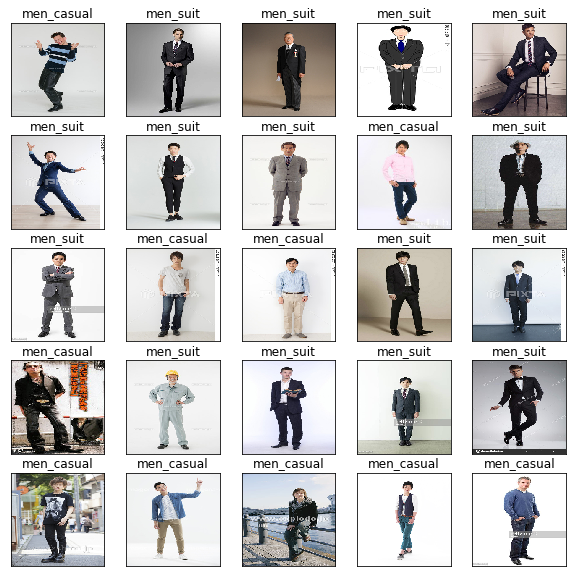

In [0]:
# 結果表示
from keras.models import model_from_json
import matplotlib.pyplot as plt
import numpy as np
import os,random
from keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

batch_size=32
test_dir='test'
#test_dir='test_moresuit'
display_dir='display'
label=['men_casual','men_suit']

#　切り替え用
file_name='1_x_entropy_acc'
#file_name='3_optimizer_default'


loss_method = 'binary_crossentropy'
metrics_method = "binary_accuracy"

#load model and weights
json_string=open(file_name+'.json').read()
model=model_from_json(json_string)
model.load_weights(file_name+'.h5')

model.compile(optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
              loss=loss_method,
              metrics=[metrics_method,P,R,F])
#data generate
test_datagen=ImageDataGenerator(rescale=1.0/255)

test_generator=test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

#evaluate model
#score=model.evaluate_generator(test_generator)
#print('\n test loss:',score[0])
#print('\n test_acc:',score[1])
##print('\n test_Precision:',score[2])
#print('\n test_Recall:',score[3])
#print('\n test_F-measure:',score[4])


#predict model and display images
files=os.listdir(display_dir)
img=random.sample(files,25)

plt.figure(figsize=(10,10))
for i in range(25):
    temp_img=load_img(os.path.join(display_dir,img[i]),target_size=(224,224))
    plt.subplot(5,5,i+1)
    plt.imshow(temp_img)
    #Images normalization
    temp_img_array=img_to_array(temp_img)
    temp_img_array=temp_img_array.astype('float32')/255.0
    temp_img_array=temp_img_array.reshape((1,224,224,3))
    #predict image
    img_pred=model.predict(temp_img_array)
    plt.title(label[np.argmax(img_pred)])
    #eliminate xticks,yticks
    plt.xticks([]),plt.yticks([])


# ８．表示・検証

In [0]:
plt.show()